In [181]:

# Pipeline to do photometry on VYSOS targets
# Vanshree Bhalotia
# Made in 2020

#############################################################################################################

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

import photutils
from photutils import aperture_photometry
from photutils import CircularAperture
from photutils import CircularAnnulus

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.io import fits
from astropy.wcs import WCS

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import QTable

from astropy.wcs import WCS
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

import pandas as pd 

#############################################################################################################

# Input things

In [182]:
# The cell where you need to input stuff.   
# All coords in degrees 

# tde_ra=255.90205 
# tde_dec=+62.02565 

search_radius= 0.5  #in degrees
maglimit = 18.0 #magnitude limit 

stdstar = 1812095
# P330E KF06T2 1808347
filters = ['V','R','i'] # <---change
filtnum = 2 #<-- 1 or 2 etc 

imnum_000i = 1
imnum_00i = 4
#imnum_00f = 16

zz = '-000'
path = '/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/'+str(stdstar)+str(zz)


rootlist = np.array([])
for i in range(imnum_000i,imnum_00i):
    rootname = path+str(i)+str(filters[filtnum])
    rootlist = np.append(rootlist,rootname)
    print(rootname)

# for i in range(imnum_00i,imnum_00f):
#     rootname = path+str(i)+str(filters[filtnum])
#     rootlist = np.append(rootlist,rootname)

/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0001i
/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0002i
/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0003i


## create Bias frame

In [183]:
#############################################################################################################

#  load bias frames & take median
#######################################
biasfilenames = []
for i in range(1,10):
    biasfilename_i = '/Users/vanshree/cosmo/bias/bias-000'+str(i)+'.fit'
    biasfilenames = np.append(biasfilenames,biasfilename_i)
biasfilenames = np.append(biasfilenames,'/Users/vanshree/cosmo/bias/bias-0010.fit')

biasarr = []

for n in range(len(biasfilenames)):
    file = str(biasfilenames[n])
    hdubias = fits.open(file)
    imbias = hdubias[0].data
    hdbias = hdubias[0].header

    biasarr.append(imbias)

# print("Shape of stacked bias-frames = ",np.shape(biasarr)) #should be 5 x 80 x 512
biasmed = np.median(biasarr, axis=0)
# print("Shape of the median image generated = ",np.shape(biasmed))

print("Mean of "+ "combined bias frame" + " is " + str(np.mean(biasmed)) + " counts ")


Mean of combined bias frame is 1133.6982711553574 counts 


## do astrometry using Astropy, GAIA DR2 autoquery to get RA & Decs & Photometry

/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0001i.fit
1979.539710098622
2021.891702658386
272.96289039756493
63.48107370039476
********************************* GAIA outputs ***************************************
272.9650142321119
63.47136702124618
2048
*********************************** Photometry *************************************
/Volumes/champa/cosmo/Cellar/astrometry-net/0.82/data/aug18_2020/1812095-0001i.fit
og xcorrd [272.44984546 272.4208501  272.44198206 272.44410053 272.44401302
 272.46693302 272.46864511 272.48510391 272.44430916 272.48680214
 272.47493629 272.53381428 272.50014157 272.50874649 272.55067971
 272.50652113 272.5586145  272.51839086 272.55425146 272.51942384
 272.5833534  272.55660048 272.57851296 272.60570979 272.62716776
 272.61547149 272.60378303 272.59540277 272.60642916 272.64043007
 272.66081611 272.65078357 272.67606495 272.63476105 272.64225215
 272.63305751 272.6916945  272.70033346 272.68769172 272.72316986
 272.72710

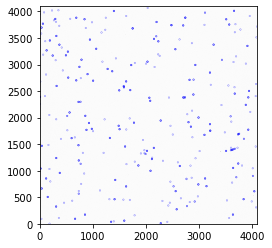

In [184]:
#############################################################################################################
# load images & astrometry outputs
#############################################################################################################
    
#######################################
# for each image ..
#######################################

for rootname in rootlist: ## for each image 
    
    imagename = rootname+'.fit'
    print(imagename)
    hdul = fits.open(imagename)
    
    image_data = fits.getdata(imagename)
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
    sources = daofind(image_data - biasmed)
#     sources = daofind(image_data - median)
    for col in sources.colnames:  
#         print(col)
        sources[col].info.format = '%.8g'  # for consistent table output
#         sources[col].info.format = '%.8g'  # for consistent table output
#     print(sources)  
    
#     id
# xcentroid
# ycentroid
# sharpness
# roundness1
# roundness2
# npix
# sky
# peak
# flux
# mag
    
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(image_data, cmap='Greys', origin='lower', norm=norm,interpolation='nearest')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    
    x_center = np.mean(sources['xcentroid'])
    y_center = np.mean(sources['ycentroid'])
    
    print(x_center)
    print(y_center)
    
    wcsimagename = rootname+'.new'
    xycoords = np.transpose((sources['xcentroid'], sources['ycentroid']))
    w = WCS(wcsimagename)
#     print(w)
    radeccoords =  w.all_pix2world(xycoords,0)
    
    ra_coord = np.array([x for x,y in radeccoords])
    dec_coord = np.array([y for x,y in radeccoords])
    
    ra_center = np.mean(ra_coord)
    dec_center = np.mean(dec_coord)
    
    print(ra_center)
    print(dec_center)
    
    print('********************************* GAIA outputs ***************************************')
    
    #DAOStarFinder.find_stars(data=image_data,mask=None)
    
#     hdul = fits.open(imagename)
#     image_data = fits.getdata(imagename)
#     im_header = hdul[0].header
#     datetime = im_header['DATE-OBS']
#     filtur = im_header['FILTER']
    
#     biassubtractedimage = image_data - biasmed

    Gaia.ROW_LIMIT=3000000 # to make sure it isn't limited to 2000
    coord = SkyCoord(ra=ra_center, dec=dec_center, unit=(u.degree, u.degree), frame='icrs')
    radius = u.Quantity(search_radius, u.deg)
    # magnitude = u.Magnitude(maglimit)

    ## selecting which colums do i want in the output file ? 
        # all avl gaia cols = [source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist]
    cols = ['source_id','ra','dec','phot_g_mean_mag']

    ## doing the Cone search
    j = Gaia.cone_search(coord, radius,table_name='gaiadr2.gaia_source', ra_column_name='ra', dec_column_name='dec',output_file='/Users/vanshree/cosmo/stdstargaia_auto.csv',dump_to_file=True,output_format='csv',columns=cols)

    ## saving cone search results to a text file 
    gaiadata_u = np.loadtxt('/Users/vanshree/cosmo/stdstargaia_auto.csv', delimiter=',',skiprows=1,)

    # col 0 source_id,
    # col 1 ra,
    # col 2 dec,
    # col 3 phot_g_mean_mag
    # col 4 dist

    gaia_srcid_u = gaiadata_u[:,0]
    gaia_ra_u = gaiadata_u[:,1]
    gaia_dec_u = gaiadata_u[:,2]
    gaia_dist_u = gaiadata_u[:,4]
    gaia_gmag_u = gaiadata_u[:,3]

    ## select only mag <= maglimit
    mask = gaia_gmag_u <= maglimit

    # filter entire file with mask & get arrays 
    gaiadata = gaiadata_u[mask]

    gaia_srcid = gaiadata[:,0]
    gaia_ra = gaiadata[:,1]
    gaia_dec = gaiadata[:,2]
    gaia_dist = gaiadata[:,4]
    gaia_gmag = gaiadata[:,3]

    ## print ( note: matches manual method)
    print(np.mean(gaia_ra))
    print(np.mean(gaia_dec))

    print(len(gaia_ra))
    
    print('*********************************** Photometry *************************************')
        # load image 
    imagename = rootname+'.fit'
    wcsimagename = rootname+'.new'
    hdul = fits.open(imagename)
    image_data = fits.getdata(imagename)
    im_header = hdul[0].header

    
    ## do astrometry
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
    sources = daofind(image_data - biasmed)
#     sources = daofind(image_data - median)
    for col in sources.colnames:  
        sources[col].info.format = '%.8g'  # for consistent table output

    xycoords = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    w = WCS(wcsimagename)
#     print(w)
    radeccoords =  w.all_pix2world(xycoords,0)
    
    xcoord = np.array([x for x,y in radeccoords])
    ycoord = np.array([y for x,y in radeccoords])
    
    print(imagename)

    datetime = im_header['DATE-OBS']
    filtur = im_header['FILTER']
    #print(im_header)


    print("og xcorrd",xcoord)
    print("og ycoord",ycoord)
#     print(len(xcoord))
    
#     # append tde RA and dec 
#     xcoord = np.append(xcoord,tde_ra)
#     ycoord = np.append(ycoord,tde_dec)
    
    print("xcoord",xcoord)
    print("ycoord",ycoord)
        
    all_the_stars_in_each_image_ra = []
    all_the_stars_in_each_image_dec = []
    gaia_all_the_stars_in_each_image_ra = []
    gaia_all_the_stars_in_each_image_dec = []

    for i in range(len(xcoord)): ## for each star in each image 
        ra_i = xcoord[i]
        dec_i = ycoord[i]
        
        ragap = 0.001666666667 #<-- 6 arseconds in degrees
        decgap = 0.001666666667 #<--
        
        
        ra_dec_match_condition = (gaia_ra<ra_i+ragap)&(gaia_ra>ra_i-ragap)&(gaia_dec<dec_i+decgap)&(gaia_dec>dec_i-decgap)        
        
        gaia_radecmatch_ra_i = gaiadata[np.where(ra_dec_match_condition),1][0]
        gaia_radecmatch_dec_i = gaiadata[np.where(ra_dec_match_condition),2][0]

        #print('rai',ra_i)
        #print('gaia_radecmatch_ra_i',gaia_radecmatch_ra_i)
        #print('gaia_radecmatch_dec_i',gaia_radecmatch_dec_i)

        
        all_the_stars_in_each_image_ra.append(ra_i)
        all_the_stars_in_each_image_dec.append(dec_i)
        
        gaia_all_the_stars_in_each_image_ra = np.concatenate([gaia_all_the_stars_in_each_image_ra,gaia_radecmatch_ra_i], axis=0)
        gaia_all_the_stars_in_each_image_dec = np.concatenate([gaia_all_the_stars_in_each_image_dec,gaia_radecmatch_dec_i], axis=0)

    ##print('gaia_all_the_stars_in_each_image_ra',gaia_all_the_stars_in_each_image_ra)
    ##print('gaia_all_the_stars_in_each_image_dec len',len(gaia_all_the_stars_in_each_image_dec))

#     print('gaiara mean',np.mean(gaia_ra))
    ##print('allstarra',all_the_stars_in_each_image_ra)
#     print('gaiadec mean',np.mean(gaia_dec))
    print('allstardec len',len(all_the_stars_in_each_image_dec))
        
    #print('len(all_the_stars_in_each_image_ra)',len(all_the_stars_in_each_image_ra))
    #print('len(all_the_stars_in_each_image_dec)',len(all_the_stars_in_each_image_dec))



#  perform  bias subtraction
#######################################

    #print('image mean',np.mean(image_data))

    biassubtractedimage = image_data - biasmed

    #print('bias subtracted image mean',np.mean(biassubtractedimage))

    

#  perform  aperture photometry
#######################################
    #print(gaia_all_the_stars_in_each_image_ra,gaia_all_the_stars_in_each_image_dec)
    #XY = np.meshgrid(gaia_all_the_stars_in_each_image_ra,gaia_all_the_stars_in_each_image_dec)
    #mat = np.array(XY).transpose()
    #print(mat)
    
    ## astropy wcs 
    ## all_world2pix()
#     w = WCS(imagename)
    w = WCS(wcsimagename)
    radeccoords = np.concatenate([gaia_all_the_stars_in_each_image_ra[:,None],gaia_all_the_stars_in_each_image_dec[:,None]], axis=1)
    print('radeccoords',radeccoords)
    
#     xycoordss = w.all_world2pix(gaia_all_the_stars_in_each_image_ra[:,None],gaia_all_the_stars_in_each_image_dec[:,None])
#     print(xycoordss)
    
    xycoords= w.all_world2pix(radeccoords,1)#,ra_dec_order=True)
    print('xycoords',xycoords)
    
    ##print('xycoordsOG',xycoords)
    ##xycoords = np.array(list(xycoords))
    ##print('xycoords',xycoords)
    
    aperture = CircularAperture(xycoords,r=5)
    annulus_aperture = CircularAnnulus(xycoords, r_in=8., r_out=10.)
    apers = [aperture, annulus_aperture]

    phot_table = aperture_photometry(biassubtractedimage,apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g' 
    print(phot_table)

    ### subtract background 
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_sum = bkg_mean * aperture.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'

    #print('\n')
    print(phot_table['residual_aperture_sum']) 


#  convert to magnitudes  
#######################################
    exptime = im_header['EXPOSURE']
    # print('exptime',exptime)

    counts_array = np.array(phot_table['residual_aperture_sum'])
    time_array = np.ones(len(counts_array))*exptime

    inst_mags_array = -2.5*np.log10(counts_array/time_array)
    print('inst_mags_array = ',inst_mags_array)

    print('datetime',datetime)
#  save outputs in a .txt file 
#######################################

    np.savetxt('/Users/vanshree/cosmo/photometry_outputs/aug18_stdstars/'+str(filtur)+'_'+str(datetime)+'.txt',np.c_[radeccoords,inst_mags_array])
    